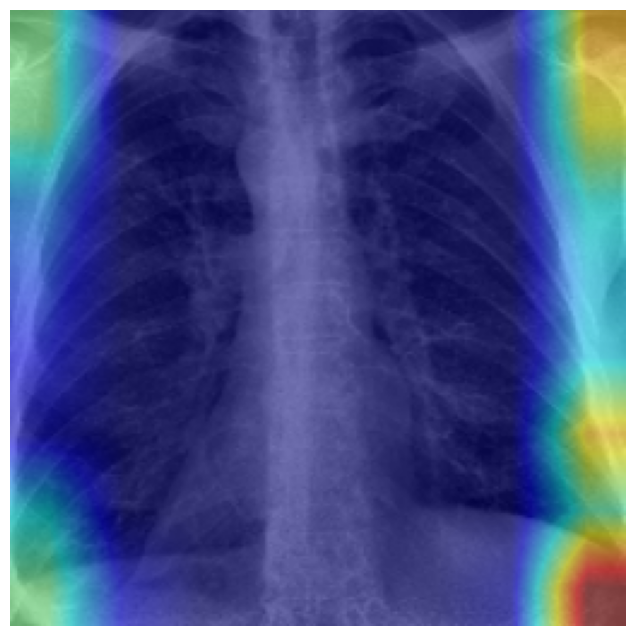

In [15]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

# Load your trained EfficientNetB0 model
model_path = "/home/axernox/Project_2/efficientnetb0.keras"
efficientnet_model = tf.keras.models.load_model(model_path)

# Function to preprocess image
def preprocess_image(img_path, img_size=(256, 256)):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize
    return img

# Function to compute Grad-CAM
def compute_gradcam(model, img_array, layer_name="top_conv"):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_class = tf.argmax(predictions[0])  # Get predicted class
        loss = predictions[:, pred_class]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0].numpy()  # Convert tensor to NumPy
    pooled_grads = pooled_grads.numpy()  # Convert to NumPy

    # Apply pooled gradients to feature maps
    for i in range(conv_outputs.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1  # Normalize

    return heatmap

# Function to overlay Grad-CAM heatmap on image
def overlay_heatmap(img_path, heatmap, alpha=0.5):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # Convert to uint8
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, alpha, heatmap, 1 - alpha, 0)
    
    # Show result
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

# Run Grad-CAM
img_path = "/home/axernox/Project_2/Lungs_Cropped/test/Sensitive/2.25.31702123180824901353633335752479228119_aug1_cropped.jpg"
img_array = preprocess_image(img_path)
layer_name = "top_conv"  # Last conv layer in EfficientNetB0
heatmap = compute_gradcam(efficientnet_model, img_array, layer_name)
overlay_heatmap(img_path, heatmap)
